In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0"
else:  
    device = "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
layer_cut = 20
network = models.vgg19(pretrained=True).cuda()
for param in network.parameters():
    param.require_grad = False
layers = list(network.features.children())
network = nn.Sequential(*layers[: (layer_cut + 1)])

In [4]:
print(network)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

torch.Size([1, 3, 450, 660])
octave: 1
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
octave: 2
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
octave: 3
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
octave: 4
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
torch.Size([777, 1140, 3])


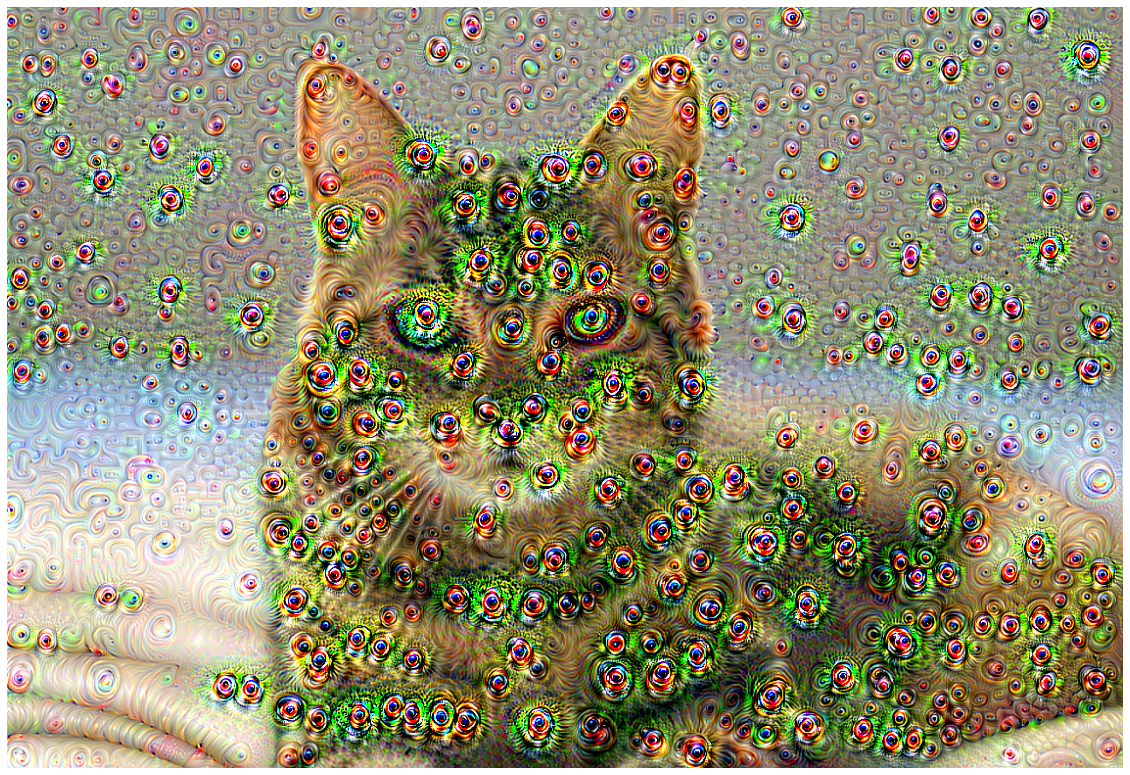

In [5]:
learning_rate = 0.5

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

image = Image.open("test.jpg")
preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
image = preprocess(image).unsqueeze(0).cpu().data.numpy()

image = torch.from_numpy(image).to(device)
image.requires_grad = True

print(image.size())

octaves = 4
iterations = 25

for octave in range(octaves):
    print("octave: {}".format(octave + 1))
    if octave != 0:
        image.requires_grad = False
        image = torch.nn.functional.interpolate(image, scale_factor=1.2, mode="bicubic", align_corners=True, recompute_scale_factor=True)
        image.requires_grad = True
    for i in range(iterations):
        network.zero_grad()
        out = network(image)
        loss = out.norm()
        loss.backward()
        image.data += learning_rate * image.grad.data
        image.grad.data.zero_()
        print("{} ".format(i + 1), end="")
    print()

image = image.detach()[0].permute(1, 2, 0) * torch.from_numpy(std).to(device).reshape((1, 1, 3)) + torch.from_numpy(mean).to(device).reshape((1, 1, 3))
image = torch.clamp(image, 0, 1)

print(image.size())

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image.cpu())